# Import Library

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load and prepare data

In [89]:
ratings = pd.read_csv("ratings.csv")[["userId", "movieId", "rating"]]
ratings

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0
...,...,...,...
99999,671,6268,2.5
100000,671,6269,4.0
100001,671,6365,4.0
100002,671,6385,2.5


# Encode user and movie IDs

In [90]:
user_enc = LabelEncoder()
movie_enc = LabelEncoder()
ratings['user'] = user_enc.fit_transform(ratings['userId'].values)
ratings['movie'] = movie_enc.fit_transform(ratings['movieId'].values)

# Normalize ratings to 0-1 range (for sigmoid output)

In [91]:
min_rating, max_rating = ratings['rating'].min(), ratings['rating'].max()
ratings['rating'] = (ratings['rating'] - min_rating) / (max_rating - min_rating)

# Split data

In [92]:
X = ratings[['user', 'movie']].values
y = ratings['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Get number of users and movies

In [93]:
n_users = ratings['user'].nunique()
n_movies = ratings['movie'].nunique()

# Model parameters

In [94]:
embedding_size = 50
hidden_units = [128, 64, 32]
dropout_rate = 0.2
l2_reg = 0.01
learning_rate = 0.001
batch_size = 64
epochs = 30

# Neural Collaborative Filtering Model

In [95]:
def create_model():
    # Input layers
    user_input = Input(shape=(1,), name='user_input')
    movie_input = Input(shape=(1,), name='movie_input')
    
    # Embedding layers
    user_embedding = Embedding(n_users, embedding_size, 
                              embeddings_regularizer=l2(l2_reg), 
                              name='user_embedding')(user_input)
    movie_embedding = Embedding(n_movies, embedding_size, 
                               embeddings_regularizer=l2(l2_reg), 
                               name='movie_embedding')(movie_input)
    
    # Flatten embeddings
    user_vec = Flatten(name='flatten_user')(user_embedding)
    movie_vec = Flatten(name='flatten_movie')(movie_embedding)
    
    # Concatenate features
    concat = Concatenate(name='concat')([user_vec, movie_vec])
    
    # Add dense layers
    x = concat
    for i, units in enumerate(hidden_units):
        x = Dense(units, activation='relu', 
                  kernel_regularizer=l2(l2_reg), 
                  name=f'hidden_{i}')(x)
        x = Dropout(dropout_rate)(x)
    
    # Output layer
    output = Dense(1, activation='sigmoid', name='output')(x)
    
    # Create model
    model = Model(inputs=[user_input, movie_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate), 
                  loss='mse', 
                  metrics=['mae', 'mse'])
    
    return model

# Create and train model

In [96]:
model = create_model()
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)       │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ movie_input (InputLayer)      │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ user_embedding (Embedding)    │ (None, 1, 50)             │          33,550 │ user_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ movie_embedding (Embedding)   │ (None, 1, 50)             │         453,300 │ movie_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_user (Flatten)        │ (None, 50)                │               0 │ user_embedding[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_movie (Flatten)       │ (None, 50)                │               0 │ movie_embedding[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concat (Concatenate)          │ (None, 100)               │               0 │ flatten_user[0][0],        │
│                               │                           │                 │ flatten_movie[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ hidden_0 (Dense)              │ (None, 128)               │          12,928 │ concat[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_9 (Dropout)           │ (None, 128)               │               0 │ hidden_0[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ hidden_1 (Dense)              │ (None, 64)                │           8,256 │ dropout_9[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_10 (Dropout)          │ (None, 64)                │               0 │ hidden_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ hidden_2 (Dense)              │ (None, 32)                │           2,080 │ dropout_10[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_11 (Dropout)          │ (None, 32)                │               0 │ hidden_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output (Dense)                │ (None, 1)                 │              33 │ dropout_11[0][0]           │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 510,147 (1.95 MB)

 Trainable params: 510,147 (1.95 MB)

 Non-trainable params: 0 (0.00 B)

# Early stopping callback

In [97]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model

In [98]:
history = model.fit(
    [X_train[:, 0], X_train[:, 1]], 
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([X_test[:, 0], X_test[:, 1]], y_test),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.6801 - mae: 0.1942 - mse: 0.0573 - val_loss: 0.0555 - val_mae: 0.1890 - val_mse: 0.0555
Epoch 2/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0551 - mae: 0.1889 - mse: 0.0551 - val_loss: 0.0555 - val_mae: 0.1890 - val_mse: 0.0555
Epoch 3/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0554 - mae: 0.1892 - mse: 0.0554 - val_loss: 0.0555 - val_mae: 0.1891 - val_mse: 0.0555
Epoch 4/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0553 - mae: 0.1893 - mse: 0.0553 - val_loss: 0.0555 - val_mae: 0.1889 - val_mse: 0.0555
Epoch 5/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0552 - mae: 0.1888 - mse: 0.0552 - val_loss: 0.0555 - val_mae: 0.1892 - val_mse: 0.0555
Epoch 6/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0551 - mae: 0.1889 - mse: 0.0551 - val_loss: 0.0555 - val_mae: 0.1890 - val_mse: 0.0555
Epoch 7/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0552 - mae: 0.1888 - mse

# Evaluation

In [99]:
test_loss, test_mae, test_mse = model.evaluate([X_test[:, 0], X_test[:, 1]], y_test)
print(f"\nTest MAE: {test_mae*(max_rating-min_rating)+min_rating:.4f}")
print(f"Test RMSE: {np.sqrt(test_mse)*(max_rating-min_rating)+min_rating:.4f}")

626/626 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0551 - mae: 0.1885 - mse: 0.0551

Test MAE: 1.3501
Test RMSE: 1.5601


In [100]:
import os
os.makedirs('plots/neural', exist_ok=True)

In [101]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='plots/neural/model_architecture.png', show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


# Visualization

In [102]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import plot_model


# Create directory for saving plots

In [103]:
os.makedirs('plots/neural', exist_ok=True)

# Set style for better looking plots

In [104]:
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

# Training History Plots

In [105]:
plt.figure(figsize=(18, 6))

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

# Loss plot

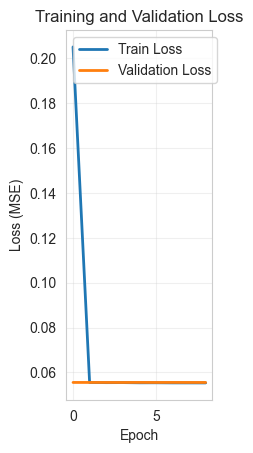

In [112]:
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=10)
plt.xlabel('Epoch', fontsize=10)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.savefig('plots/neural/Training_and_Validation_Loss.png', bbox_inches='tight')

# MAE plot (original scale)

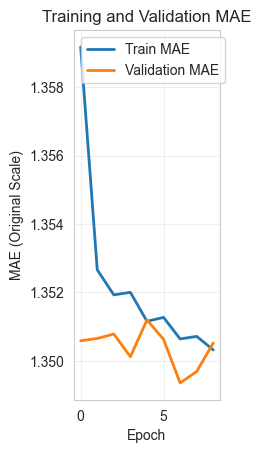

In [113]:
plt.subplot(1, 3, 2)
train_mae = np.array(history.history['mae'])*(max_rating-min_rating)+min_rating
val_mae = np.array(history.history['val_mae'])*(max_rating-min_rating)+min_rating
plt.plot(train_mae, label='Train MAE', linewidth=2)
plt.plot(val_mae, label='Validation MAE', linewidth=2)
plt.title('Training and Validation MAE', fontsize=12)
plt.ylabel('MAE (Original Scale)', fontsize=10)
plt.xlabel('Epoch', fontsize=10)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.savefig('plots/neural/Training_and_Validation_MAE.png', bbox_inches='tight')

# Prediction Distribution Plot

626/626 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


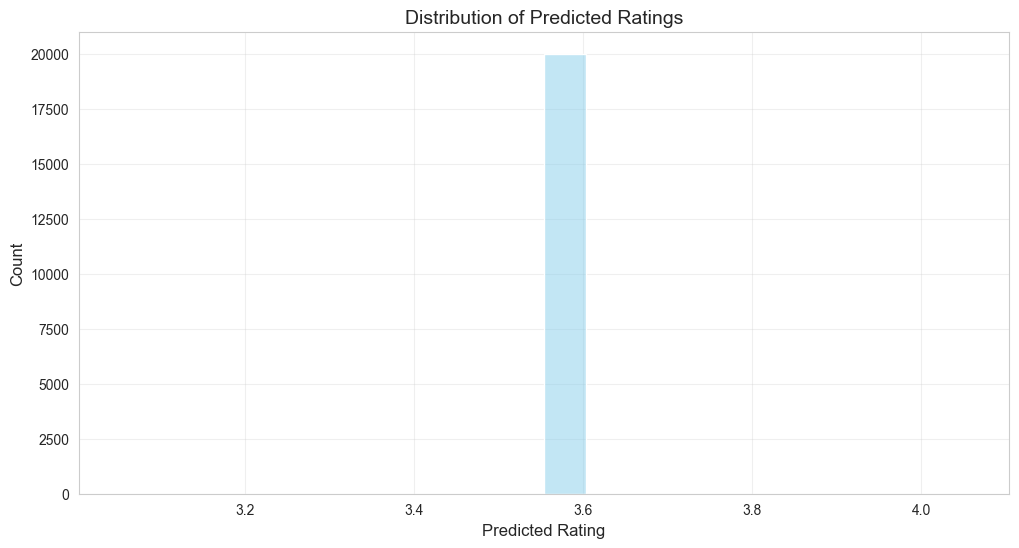

Prediction distribution plot saved to plots/neural/prediction_distribution.png


In [108]:
test_predictions = model.predict([X_test[:, 0], X_test[:, 1]]).flatten()
test_predictions = test_predictions * (max_rating - min_rating) + min_rating

plt.figure(figsize=(12, 6))
sns.histplot(test_predictions, bins=20, kde=True, color='skyblue')
plt.title('Distribution of Predicted Ratings', fontsize=14)
plt.xlabel('Predicted Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(True, alpha=0.3)
plt.savefig('plots/neural/prediction_distribution.png', bbox_inches='tight')
plt.show()
print("Prediction distribution plot saved to plots/neural/prediction_distribution.png")


# Actual vs Predicted Ratings Scatter Plot

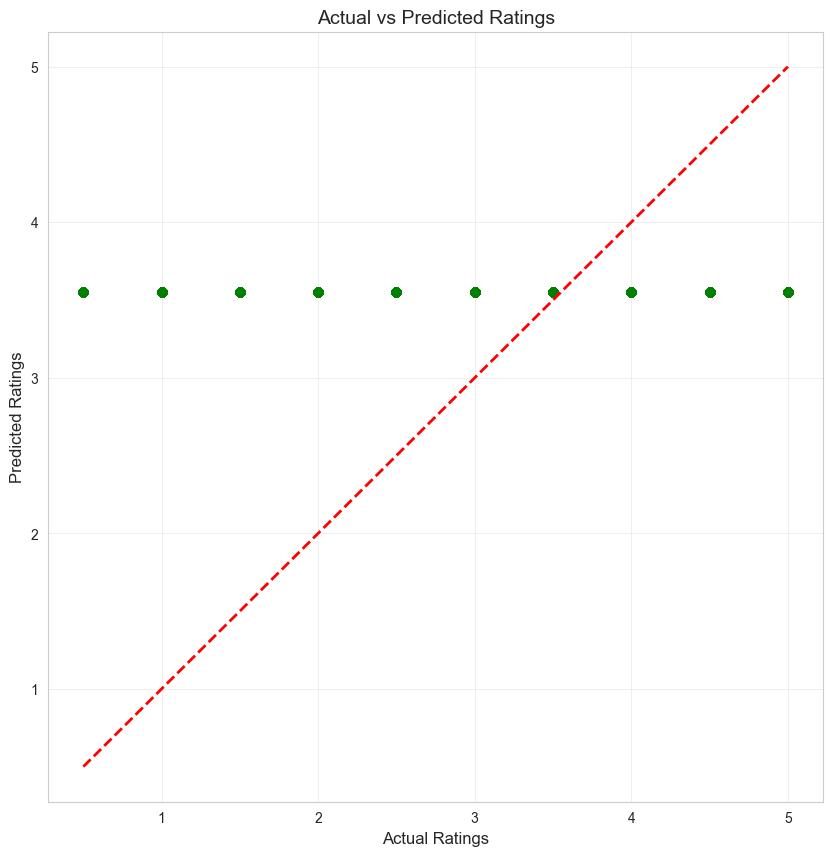

Actual vs predicted plot saved to plots/neural/actual_vs_predicted.png


In [109]:
y_test_original = y_test * (max_rating - min_rating) + min_rating

plt.figure(figsize=(10, 10))
plt.scatter(y_test_original, test_predictions, alpha=0.3, color='green')
plt.plot([min_rating, max_rating], [min_rating, max_rating], 'r--', linewidth=2)
plt.title('Actual vs Predicted Ratings', fontsize=14)
plt.xlabel('Actual Ratings', fontsize=12)
plt.ylabel('Predicted Ratings', fontsize=12)
plt.grid(True, alpha=0.3)
plt.savefig('plots/neural/actual_vs_predicted.png', bbox_inches='tight')
plt.show()
print("Actual vs predicted plot saved to plots/neural/actual_vs_predicted.png")

# Sample Predictions with Error Bars

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


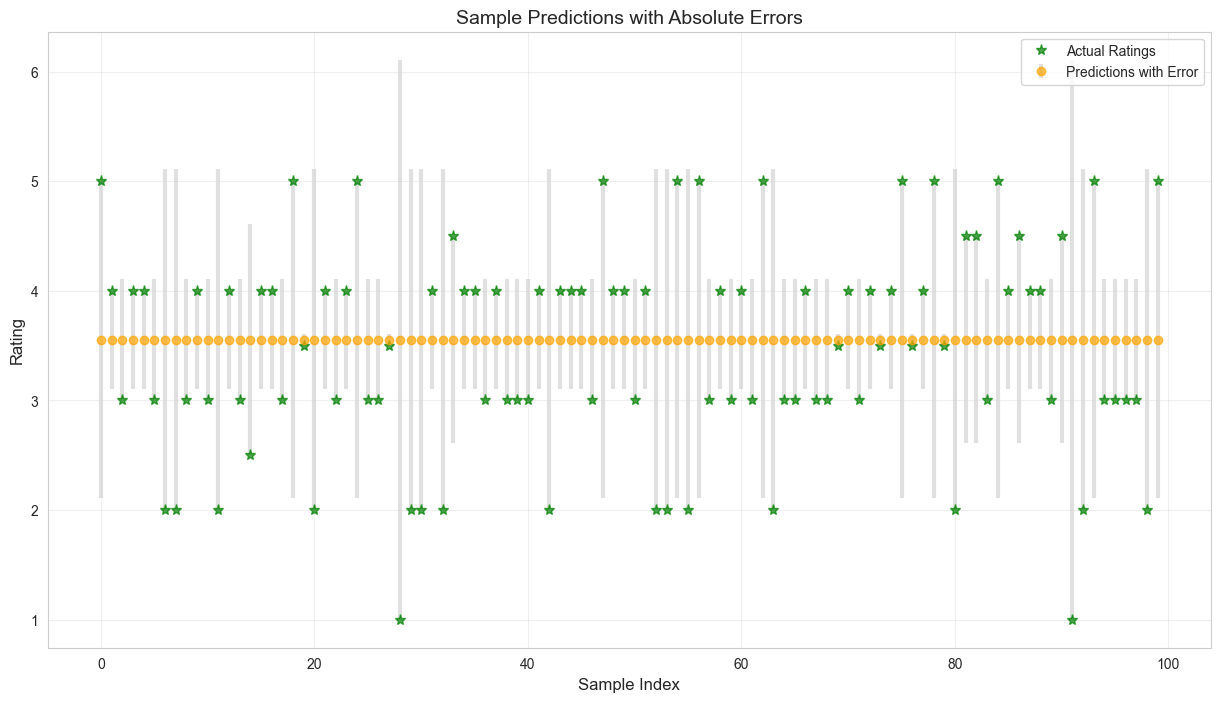

Sample predictions plot saved to plots/neural/sample_predictions_with_errors.png


In [110]:
sample_size = 100
sample_indices = np.random.choice(len(X_test), sample_size, replace=False)
sample_X = X_test[sample_indices]
sample_y = y_test[sample_indices]

sample_preds = model.predict([sample_X[:, 0], sample_X[:, 1]]).flatten()
sample_preds = sample_preds * (max_rating - min_rating) + min_rating
sample_y = sample_y * (max_rating - min_rating) + min_rating
errors = np.abs(sample_y - sample_preds)

plt.figure(figsize=(15, 8))
plt.errorbar(range(sample_size), sample_preds, yerr=errors, 
             fmt='o', color='orange', ecolor='lightgray', 
             elinewidth=3, capsize=0, alpha=0.7, label='Predictions with Error')
plt.plot(range(sample_size), sample_y, 'g*', markersize=8, alpha=0.7, label='Actual Ratings')
plt.title('Sample Predictions with Absolute Errors', fontsize=14)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.savefig('plots/neural/sample_predictions_with_errors.png', bbox_inches='tight')
plt.show()
print("Sample predictions plot saved to plots/neural/sample_predictions_with_errors.png")

# Enhanced Sample Recommendations Table

In [111]:
print("\nSample Recommendations:")
for i, (user, movie) in enumerate(zip(sample_users, sample_movies)):
    pred = model.predict([np.array([user]), np.array([movie])])[0][0]
    original_rating = pred * (max_rating - min_rating) + min_rating
    print(f"{i+1}. User {user_enc.inverse_transform([user])[0]} "
          f"predicted rating for movie {movie_enc.inverse_transform([movie])[0]}: "
          f"{original_rating:.2f}")


Sample Recommendations:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1. User 599 predicted rating for movie 4495: 3.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2. User 330 predicted rating for movie 5153: 3.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
3. User 521 predicted rating for movie 2829: 3.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
4. User 80 predicted rating for movie 3875: 3.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
5. User 146 predicted rating for movie 54276: 3.55
